# Image reconstruction by autoencoder

In [1]:
import os


import tensorflow as tf
import helpers as helpers
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys

import numpy as np
!pwd

%cd ..
%ls
!source set_env.sh
%cd scripts

print(os.environ['DATA'])


Using TensorFlow backend.


/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM/semi_supervised_learning/scripts
/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM/semi_supervised_learning
README.md              loss_lists/            set_env.sh
data/                  models/                set_env_preprocess.sh
data_nopreprocess/     plots/                 test/
logs/                  scripts/
/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM/semi_supervised_learning/scripts
/Users/nabarundev/Anomaly-Detection-for-ECAL-DQM/semi_supervised_learning/data_nopreprocess/good_2016


## Look at a good input image and then its reconstruction
Load a good input image and plot it. These are ECAL Barrel rechit occupancy images.

0.105488
8.99068
Shape of image is:  (170, 360)


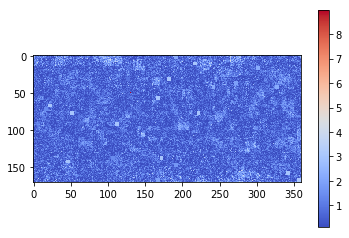

In [45]:

prep_level=4
data_sample=helpers.get_data("ECAL_rechit_occ_time_276582.hdf5",data_type='good_2016',preprocess_level=prep_level)
#data_sample=get_data("ECAL_rechit_occ_time_276582.hdf5",data_type='good_2016',preprocess_level=prep_level)

input_image=data_sample[0,:]

print(np.min(input_image))
print(np.max(input_image))
print("Shape of image is: ",input_image.shape)
im=plt.imshow(input_image,cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()
input_image=np.reshape(input_image,(1,1,input_image.shape[0],input_image.shape[1]))

The above is what a good input image looks like. Now load a trained autoencoder model and plot its reconstruction.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 170, 360)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 34, 72)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 34, 72)         136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 34, 72)         288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 34, 72)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 34, 72)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 17, 36)         0         
__________

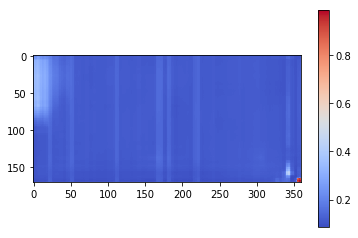

In [66]:
import keras.models as models
model_name='model_v49_MSE_adadelta'
trained_model=models.load_model(os.environ['BASEDIR']+"/models/"+model_name+".h5")
trained_model.summary()
reconstructed_image=trained_model.predict(input_image)
reconstructed_image=np.reshape(reconstructed_image,(input_image.shape[2],input_image.shape[3]))
print(np.min(reconstructed_image))
print(np.max(reconstructed_image))
im=plt.imshow(reconstructed_image,cmap=cm.coolwarm)
plt.colorbar()
plt.show()

In [76]:
layer_dict = dict([(layer.name, layer) for layer in trained_model.layers])
weights_1=layer_dict['conv2d_7'].get_weights()
weight_array=np.array(weights_1)
print(weight_array.shape)
print(weight_array[0][1])

(2,)
[[[ 0.02043588]
  [-0.00190427]
  [ 0.0186619 ]
  [-0.04544577]
  [ 0.00949717]
  [ 0.02427308]
  [-0.02097162]
  [ 0.02687919]]

 [[-0.04154941]
  [ 0.00242145]
  [-0.15629144]
  [ 0.03557157]
  [-0.0144112 ]
  [-0.0311134 ]
  [ 0.00913362]
  [-0.06304857]]

 [[-0.04597763]
  [-0.02879672]
  [ 0.13660473]
  [-0.0078045 ]
  [-0.04955575]
  [-0.12468892]
  [ 0.02026657]
  [-0.00746263]]

 [[-0.02040026]
  [ 0.03147643]
  [-0.01062168]
  [ 0.06696826]
  [ 0.02977768]
  [ 0.04143978]
  [-0.03450948]
  [-0.03214131]]

 [[ 0.02995868]
  [-0.01529272]
  [ 0.0127655 ]
  [-0.0688776 ]
  [-0.00654072]
  [-0.00641673]
  [ 0.00910219]
  [ 0.04638011]]]


The reconstructed image looks like above. It is expected that is blurred as above. The autoencoder trained is undercomplete and reconstructs the image back from a lower dimensional representation (over latent varaibles.). It is expected to capture the important features of the images. 



Moving on, training and testing loss spectrums look as follows. 

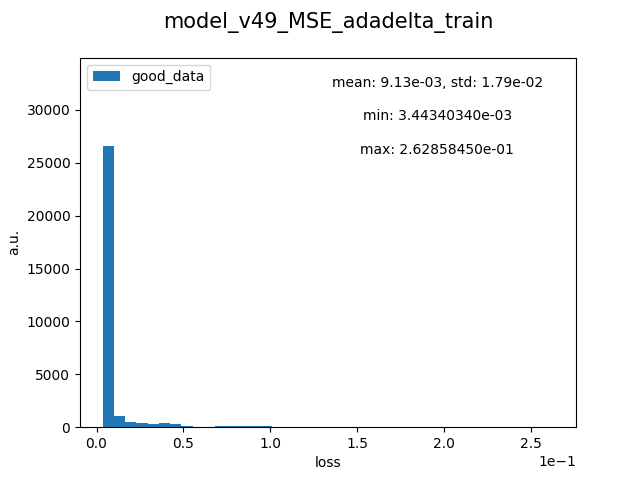

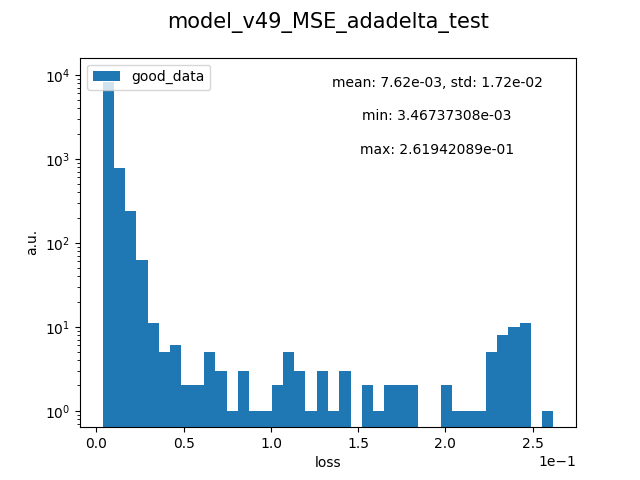

In [68]:
from IPython.display import Image,display
display(Image(filename=os.environ['BASEDIR']+"/plots/loss_as_metric/"+model_name.replace("best_model","autoencoder")+"_train.png") )
display(Image(filename=os.environ['BASEDIR']+"/plots/loss_as_metric/"+model_name+"_test.png") )

Testing and traing loss spectrum are similar. Seems to generalize well as far as reconstructing images are concerned. But thats not exactly what we are trying to do.

## Let us see what happens with bad data.
First, lets look at some artificial (bad) data with hot towers.

0.00185708
74.6393


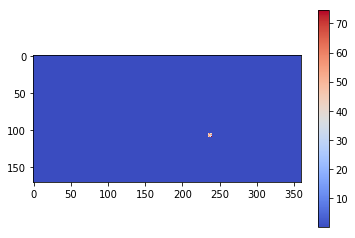

In [69]:
data_sample=helpers.get_data("ECAL_rechit_occ_time_276582.hdf5",data_type='bad_2016/hot_towers',preprocess_level=prep_level)
input_image=data_sample[0,:]
print(np.min(input_image))
print(np.max(input_image))
im=plt.imshow(input_image,cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()

input_image=np.reshape(input_image,(1,1,input_image.shape[0],input_image.shape[1]))


Now let us look at its reconstruction.

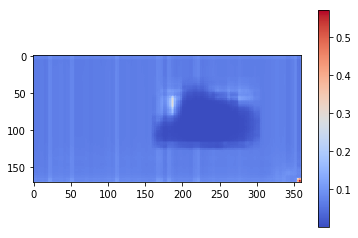

In [70]:
reconstructed_image=trained_model.predict(input_image)
reconstructed_image=np.reshape(reconstructed_image,(input_image.shape[2],input_image.shape[3]))
im=plt.imshow(reconstructed_image,cmap=cm.coolwarm)
plt.colorbar()
plt.show()


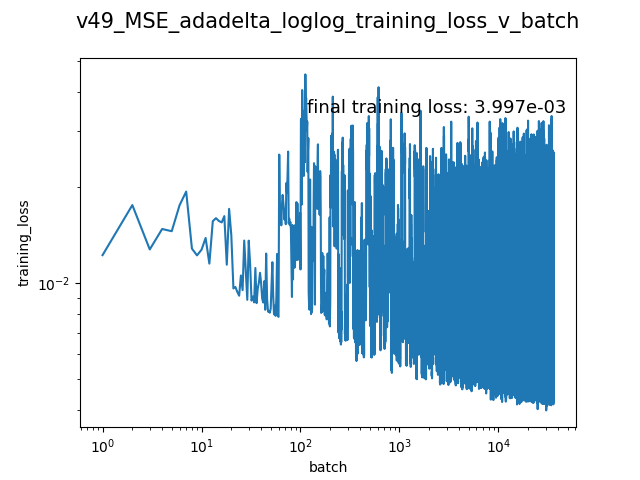

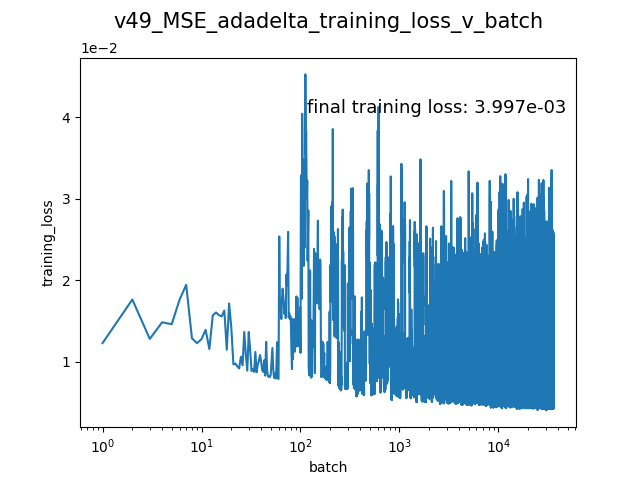

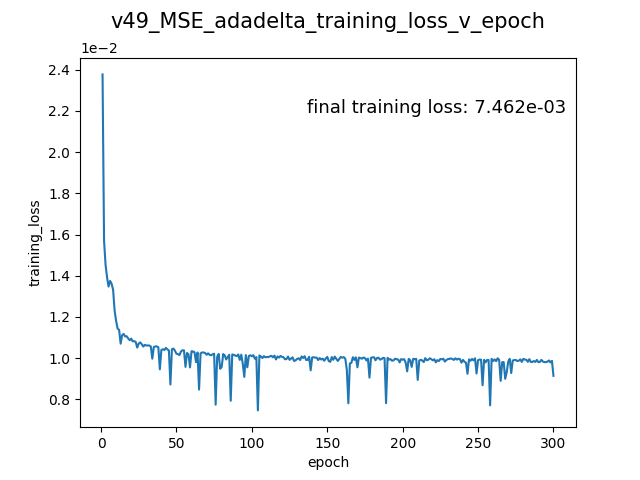

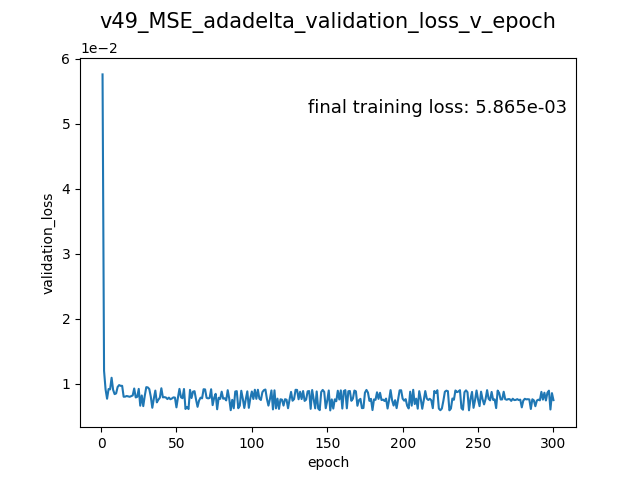

In [71]:
display(Image(filename=os.environ['BASEDIR']+"/plots/train_val_losses/"+model_name.replace("autoencoder_","").replace("best_model_","").replace("model_","")+"_loglog_training_loss_v_batch.png"))
display(Image(filename=os.environ['BASEDIR']+"/plots/train_val_losses/"+model_name.replace("autoencoder_","").replace("best_model_","").replace("model_","")+"_training_loss_v_batch.png"))
display(Image(filename=os.environ['BASEDIR']+"/plots/train_val_losses/"+model_name.replace("autoencoder_","").replace("best_model_","").replace("model_","")+"_training_loss_v_epoch.png"))
display(Image(filename=os.environ['BASEDIR']+"/plots/train_val_losses/"+model_name.replace("autoencoder_","").replace("best_model_","").replace("model_","")+"_validation_loss_v_epoch.png"))


Hmmmm.., now lets see how the loss spectrum over several such images (these images were manufactured using randomly picked good images and making a tower hot and then renormalizing) look like compared to loss spectrum of good test images.

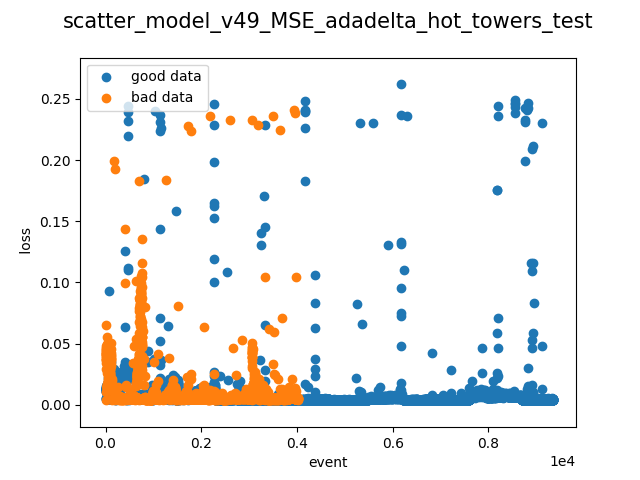

In [72]:
display(Image(filename=os.environ['BASEDIR']+"/plots/loss_as_metric/scatter_"+model_name+"_hot_towers_test.png") )

The reconstructed loss spectrums are different. Roc(TP_vs_FP)_AUC is >0.99. 

Next look at a different type of (artificial) bad data, images with missing modules. Such an image is shown below.

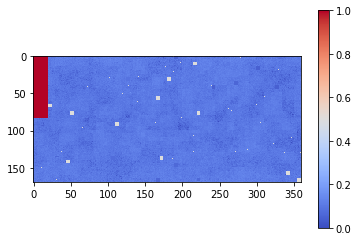

In [73]:
data_sample=helpers.get_data("ECAL_rechit_occ_time_276582.hdf5",data_type='bad_2016/missing_modules',preprocess_level=4)
input_image=data_sample[0,:]
im=plt.imshow(input_image,cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()
input_image=np.reshape(input_image,(1,1,input_image.shape[0],input_image.shape[1]))


Now look at its reconstruction.

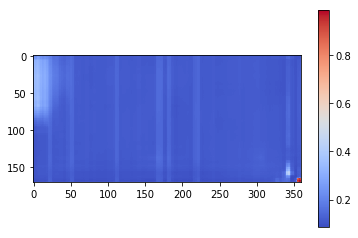

In [74]:
reconstructed_image=trained_model.predict(input_image)
reconstructed_image=np.reshape(reconstructed_image,(input_image.shape[2],input_image.shape[3]))
im=plt.imshow(reconstructed_image,cmap=cm.coolwarm)
plt.colorbar()
plt.show()


Lets look at the loss spectrum compared to loss spectrum of test images, just like before.

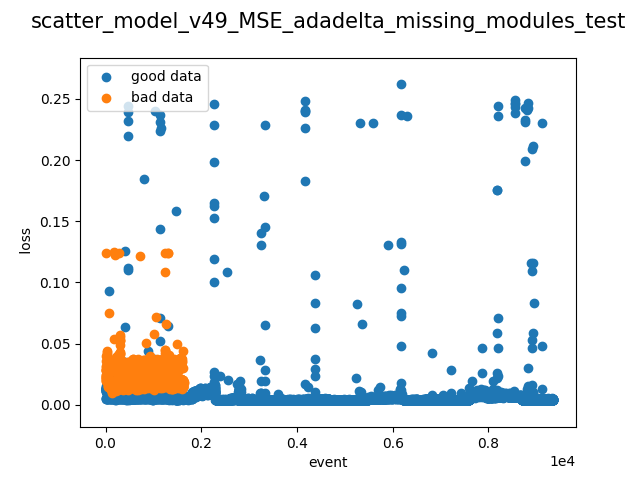

In [75]:
display(Image(filename=os.environ['BASEDIR']+"/plots/loss_as_metric/scatter_"+model_name+"_missing_modules_test.png") )

This obviously doesn't work well....... Technique needs to be improved a lot more. The reconstruction appears to blur out the edges of the missing module but overall does a similar job as when reconstructing good images. We need better prepocessing techniques and more sopisticated models...?